# Perturbation for cross-feeding consumer resource model 

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy
from __future__ import division
import pandas as pd
from numpy.random import dirichlet
import numbers

import seaborn as sns

import pandas as pd
from itertools import product
#from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle
import os
import time


from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


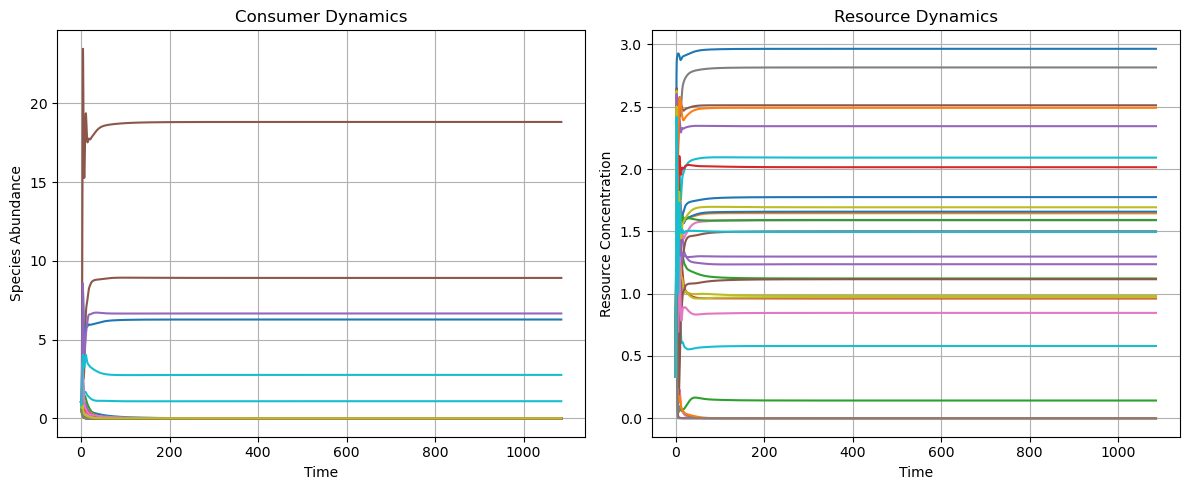

In [2]:


def simulate_monod_crm(initial_state, C, E, h, m, K,
                                 max_time=500000, steady_state_threshold=1e-12):
    """
    Simulate the ODE system until steady state or max_time is reached.

    Parameters:
    -----------
    initial_state : np.ndarray
        Concatenated vector [N_init, R_init], length S + M.
    C : np.ndarray
        Consumption matrix, shape (S, M).
    E : np.ndarray
        Effect matrix, shape (S, M).
    h : float
        Half-saturation constant.
    m : np.ndarray
        Species mortality vector, shape (S,).
    K : np.ndarray
        Resource carrying capacities, shape (M,).
    max_time : float
        Maximum simulation time.
    steady_state_threshold : float
        Steady state threshold for all derivatives.

    Returns:
    --------
    sol : OdeResult
        Output object from scipy's solve_ivp.
    """
    S, M = C.shape

    def Monod_CRM(t, state):
        N = state[:S]
        R = state[S:]
        
        growth_terms = C @ (R / (h + R))  # shape (S,)
        
        dNdt = N * (growth_terms - m)

        denom = h + R  # (S, M)
    
        consumption_terms = E.T @ N  /denom # shape (M,)
      
        dRdt = R * (K - R - consumption_terms)

        return np.concatenate([dNdt, dRdt])

    # Event to detect steady state
    def check_steady_state(t, y):
        derivatives = Monod_CRM(t, y)
        return np.max(np.abs(derivatives)) - steady_state_threshold

    check_steady_state.terminal = True
    check_steady_state.direction = -1  # Detect when system enters threshold
    
    sol = solve_ivp(
        Monod_CRM,
        t_span=(0, max_time),
        y0=initial_state.copy(),
        method='LSODA',
        atol=1e-10,
        rtol=1e-10,
        events=[check_steady_state]
    )

    if sol.t[-1] == max_time:
        print('max integration time reached')

    return sol

def generate_E(E_mean, top_species, resources, rho, zero_mean_c ):
    zero_mean_d = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    return E_mean/resources + rho * zero_mean_c   + np.sqrt(1 - rho**2) * zero_mean_d


def generate_model_params(top_species, resources, C_mean, C_std_dev, rho, u_mean, m_std_dev, k_mean, k_std_dev):
    zero_mean_c = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    C = C_mean/resources + zero_mean_c
    m = np.random.normal(u_mean, m_std_dev,top_species)
    E = generate_E(C_mean, top_species, resources, rho, zero_mean_c)
    k = np.random.normal(k_mean, k_std_dev,resources)
    return C, m, E, k

# Example simulation and plotting
import matplotlib.pyplot as plt

# Set parameters
S = 30  # Number of species
M = 30  # Number of resources
h = 3  # Half-saturation constant

mean_c = 3            # Mean consumption rate
C_std_dev = 1         # Standard deviation of consumption
rho = 1               # Correlation coefficient

# Generate model parameters
C, m, E, k = generate_model_params(S, M, mean_c, C_std_dev, rho, 
                                 u_mean=1, m_std_dev=0,
                                 k_mean=3, k_std_dev=0)

# Initial conditions
N0 = np.ones(S)  # Initial species abundances
R0 = np.ones(M)/3    # Initial resource concentrations at carrying capacity
initial_state = np.concatenate([N0, R0])
# Run simulation
sol = simulate_monod_crm(initial_state, C, E, h, m, k, max_time=10000,steady_state_threshold=1e-10)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot species abundances
for i in range(S):
    ax1.plot(sol.t, sol.y[i], label=f'Species {i+1}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Species Abundance')
#ax1.set_yscale('log')
ax1.grid(True)
ax1.set_title('Consumer Dynamics')

# Plot resource concentrations
for j in range(M):
    ax2.plot(sol.t, sol.y[S+j], label=f'Resource {j+1}')
ax2.set_xlabel('Time')
ax2.set_ylabel('Resource Concentration')
#ax2.set_yscale('log')
ax2.grid(True)
ax2.set_title('Resource Dynamics')

plt.tight_layout()
plt.show()







In [12]:
def find_steady_state(C, m, E, k, h, max_time=10000, survival_threshold=1e-5):
    """
    Run simulation and find the steady state abundances.
    
    Parameters:
    C: Consumption matrix
    m: Maintenance vector
    E: Conversion matrix
    k: Resource supply rates
    h: Half-saturation constant
    max_time: Maximum simulation time
    survival_threshold: Threshold below which species are considered extinct
    
    Returns:
    final_abundances: Array of steady state abundances, with extinct species set to 0
    """
    S, M = C.shape
    
    # Initial conditions
    N0 = np.ones(S)  # Initial species abundances
    R0 = np.ones(M)/3  # Initial resource concentrations
    initial_state = np.concatenate([N0, R0])
    
    # Run simulation
    sol = simulate_monod_crm(initial_state, C, E, h, m, k, 
                           max_time=max_time,
                           steady_state_threshold=1e-10)
    
    # Get final abundances from the last timepoint
    final_abundances = sol.y[:S, -1]  # Only take species abundances, not resources
    
    # Set species below threshold to 0
    final_abundances[final_abundances < survival_threshold] = 0
    # Get final resource concentrations from the last timepoint
    final_resources = sol.y[S:, -1]  # Take resource concentrations after species abundances
    
    return final_abundances, final_resources
    return final_abundances

In [13]:
import numpy as np

def update_ext_bool(original, shift, survival_threshold=1e-5): #bring those shifting to negatie to extinct
    original_plus_shift=original+shift
    Extbool=np.array([(x <= survival_threshold) for x in original_plus_shift])
    return Extbool

def general_perturbation_prediction(A,X,u,delta_u,knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum=0.1,immortal=None,A_IS_eff=None):
    if delta_u is None:delta_u = np.zeros(len(u)) #perturbed environment
    if knock_off is None:knock_off = np.array([False]*len(A), dtype=bool) #something that has to extinct
    if immortal is None: immortal = np.array([False]*len(A), dtype=bool) #something that has to survive
        
    sumX=np.sum(X)
    num_immortal=sum(immortal)
    num_invaders=len(A_II)
    X_IList=[]
    deltaXList=[]
    predicted_XList=[]
    Ebool=np.array(knock_off, dtype=bool)  # Ensure boolean type
    Sbool= np.logical_not(Ebool)
    Ebool_I = np.array([False]*num_invaders, dtype=bool)  # Ensure boolean type
    Sbool_I= np.logical_not(Ebool_I)
    deltaX = -sumX*Ebool.astype(int)
    X_I=np.zeros(num_invaders)
    
    for i in range(num_iters):
        Sbool= np.logical_not(Ebool)
        Sbool_I= np.logical_not(Ebool_I) 
        
        X_S = X[Sbool]
        X_E = X[Ebool]
        A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
        A_SE=A[Sbool,::][::,Ebool]
        delta_u_S=delta_u[Sbool]
        #num_invaders=sum(Sbool_I)
        if num_invaders>0:
            A_IS_s=A_IS[Sbool_I,::][::,Sbool]
            A_SI_s=A_SI[Sbool,::][::,Sbool_I]
            A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
            u_I_s=u_I[Sbool_I]
            X_I_s=X_I[Sbool_I]
            if A_IS_eff is not None:
                A_IS_eff_s=A_IS_eff[Sbool_I,::][::,Sbool]
                M_inv=np.linalg.inv(A_II_s-A_IS_eff_s@A_SS_inv@A_SI_s)
                X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_eff_s@A_SS_inv@(delta_u_S+A_SE@X_E))
            else:
                M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
                X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))

            #removing invaders if it goes negative or explode to infinity
            for j in range(len(X_I_s)):
                if X_I_s[j]<0 or X_I_s[j]>sumX:
                    X_I_s[j]=0
                    Ebool_I[j]=True
                    
            X_I[Sbool_I]=X_I_s
            
            deltaX_new=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
        
        else: 
            deltaX_new=A_SS_inv@(delta_u_S+A_SE@X_E)
            #X_I=[]
        
        #if np.sum((deltaX_new-deltaX[Sbool])**2)<accuracy: #check convergence, break if converged
        #    break
        if i==0: #first iteration
            deltaX[Sbool]=deltaX_new
        else:   
            # instead of update to delta_new directly, we do momentum updates to improve convergence 
            deltaX[Sbool]=copy.deepcopy(deltaX[Sbool])*momentum+(1-momentum)*deltaX_new
            
        XExtgrowth=u[Ebool]-A[Ebool,::][::,Sbool]@(X_S+deltaX[Sbool])
        if num_invaders>0: X_IExtgrowth=u_I[Ebool_I]-A_IS[Ebool_I,::][::,Sbool]@(X_S+deltaX[Sbool])
        
        oldEbool=copy.deepcopy(Ebool)
        
        #bringing back the species with positive growth rates except knock-offs
        Ebool[Ebool]=[(x < 1e-8) for x in XExtgrowth] 
        # print('Ebool, knock_off',Ebool, knock_off)
        Ebool[knock_off]=knock_off[knock_off]
        if num_invaders>0: Ebool_I[Ebool_I]=[(x < 0) for x in X_IExtgrowth] 
        
        #removing species with negative abundance after proposed shift
        Ebool[Sbool] = update_ext_bool(X[Sbool], deltaX[Sbool])

        #make sure all immortal species are surviving 
        Ebool[immortal]=np.array([False]*num_immortal)
                
        #save result
        X_IList.append(X_I)
        deltaXList.append(deltaX)
        
        predicted_X=np.concatenate((np.clip(deltaX+X, 0, None),X_I))
        predicted_XList.append(predicted_X)
        
        #check convergence
        if np.all(oldEbool==Ebool):
            break
    return X_IList, deltaXList,  predicted_XList, A_SS_inv@A_SI_s


def prediction_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,knock_off): 
    num_invaders=len(u_I)
    Ebool_I= np.logical_not(Sbool_I)
    Ebool= np.logical_not(Sbool)
    not_knock_off=np.logical_not(knock_off)
    Ebool[knock_off]=True
    X_I=np.zeros(num_invaders)
    deltaX=np.zeros(len(A))
    
    X_S = X[Sbool]
    X_E = X[Ebool]
    A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
    A_SE=A[Sbool,::][::,Ebool]
    delta_u_S=delta_u[Sbool]
    A_IS_s=A_IS[Sbool_I,::][::,Sbool]
    A_SI_s=A_SI[Sbool,::][::,Sbool_I]
    A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
    u_I_s=u_I[Sbool_I]
    X_I_s=X_I[Sbool_I]
    
    M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
    X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))
    deltaXs=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
    
    deltaX[Sbool]=deltaXs
    X_I[Sbool_I]=X_I_s
    newX=deltaX+X
    newX[Ebool]= 0
    predicted_X=np.concatenate((newX,X_I))
    screened_invader_impact=np.ndarray.flatten(A_SS_inv@A_SI_s)
    return predicted_X, screened_invader_impact,M_inv

def create_block_matrix(A, B, C, D):   

    # Create the block matrix using np.block
    block_matrix = np.block([
        [A, B],
        [C, D]
    ])
    
    return block_matrix

def make_A(C,E,Q):
    # Print shapes of input matrices

    zeros=np.zeros((len(C),len(C)))
    # Create the block matrix using create_block_matrix
    A = create_block_matrix(zeros, C,E.T, Q)
    
    return A

def make_X(N,R):
    X=np.concatenate((N,R))
    return X

def make_u(m,k):
    u=np.concatenate((-m,k))
    return u

#make_A(C,E,np.eye((len(C.T))))
def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array

def predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1, E_IS_eff=None, C_I_eff=None):
    
    num_invaders=len(m_I)
    num_native=len(Cs)
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(len(Qs)))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_IS_eff=np.block([[np.zeros((num_invaders,num_native)),C_I_eff]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*len(Qs))), dtype=bool)
    _, _,  predicted_XList, screen_invader_impact=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I,immortal=None, num_iters=50, momentum=0.1, A_IS_eff=A_IS_eff)
    perturbation_prediction = np.array(predicted_XList)[-1]
    perturbation_prediction = np.array(predicted_XList)[-1]   
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+len(Qs)]
    invader_N_prediction=perturbation_prediction[num_native+len(Qs):]

    return np.concatenate((native_N_prediction,invader_N_prediction)), native_R_prediction



def info_predict_CRM_with_LV(Cs,Es, Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,delta_m,knock_off,N_simulator_Sbool,R_simulator_Sbool):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*resources)))
    full_simulator_Sbool=np.concatenate((N_simulator_Sbool,R_simulator_Sbool))
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
    perturbation_prediction,screened_invader_impact,M_inv=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,full_knock_off)
    

    screened_invader_impact_N=screened_invader_impact[:-resources]
    screened_invader_impact_R=screened_invader_impact[-resources:]
    
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+resources]
    invader_N_prediction=perturbation_prediction[num_native+resources:]
    
    return np.concatenate((native_N_prediction,invader_N_prediction)),native_R_prediction, screened_invader_impact_N,screened_invader_impact_R, M_inv


def consumer_invasion_and_knock_off(C, E, C_I, E_I, m, m_I, knock_off):
    not_knock_off= np.logical_not(knock_off)
    C_new=np.concatenate((C[not_knock_off],C_I))
    E_new=np.concatenate((E[not_knock_off],E_I))
    m_new = np.concatenate((m[not_knock_off], m_I))
    return C_new, E_new, m_new

def deduce_extinction_threshold_log(data):
    """
    Deduce a threshold for extinction in abundance data using the log distribution and the middle of the gap.
    
    Parameters:
    data (array-like): Array of abundance data.
    
    Returns:
    float: The deduced extinction threshold.
    """
    data = np.array(data)
    data_nonzero = data[data > 0]  # Remove zero or negative values to avoid log issues
    log_data = np.log(data_nonzero)
    
    # Sort the log-transformed data
    sorted_log_data = np.sort(log_data)
    
    # Find the middle of the largest gap in the log-transformed data
    log_gaps = np.diff(sorted_log_data)
    max_gap_index = np.argmax(log_gaps)
    
    middle_of_gap = (sorted_log_data[max_gap_index] + sorted_log_data[max_gap_index + 1]) / 2
    
    # Convert back from log scale to original scale
    threshold = np.exp(middle_of_gap)
    
    return threshold

def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}

def form_matrices(C, E, N, R, h, C_I, E_I):
    """
    Form the mapped effective matrices C, E, Q, and vector C_I in perturbation theory for Monod CRM.

    Parameters:
    C (np.ndarray): Matrix C_{iα} with shape (S, M).
    E (np.ndarray): Matrix E_{jα} with shape (S, M).
    N (np.ndarray): Vector of species abundances N_j with shape (S,).
    R (np.ndarray): Vector of resource concentrations R_α with shape (M,).
    h (np.ndarray): Vector h_i (or h_j) with shape (S,).
    get_CI (bool): Whether to compute and return C_I.

    Returns:
    C_matrix (np.ndarray): \( C_{i\alpha} \to \frac{C_{i\alpha} h_i}{(h_i - R_\alpha)^2} \)
    E_matrix (np.ndarray): \( E_{j\alpha} \to \frac{E_{j\alpha}}{(h_j + R_\alpha)^2} \)
    Q_matrix (np.ndarray): \( Q_{\alpha\beta} = \delta_{\alpha\beta} - \delta_{\alpha\beta}\sum_j \frac{E_{j\alpha} N_j}{(h_j + R_\alpha)^2} \)
    C_I (np.ndarray): \( C_{0\alpha} = \sum_i \frac{C_{i\alpha}}{h_i + R_\alpha} \) if get_CI else None
    """
    S, M = C.shape
        # (S, 1) to broadcast with (S, M)
    R = R.reshape(1, M)      # (1, M) to broadcast with (S, M)

    # 1. C_matrix: elementwise
    C_eff = C * h / (h + R) ** 2

    # 2. E_matrix: elementwise
    E_eff = E / (h + R) 
    
    # 3. Q_matrix: diagonal matrix
    Q_diag = 1 - np.sum(E * N.reshape(S, 1) / (h + R) ** 2, axis=0)
    Q_eff = np.diag(Q_diag)

    # 4. invader vectors
    C_I_finv = C_I / (h + R)
    C_I_eff = C_I * h / (h + R) ** 2
    E_I_eff = E_I /  (h + R)


    return C_eff, E_eff, Q_eff, C_I_finv, C_I_eff, E_I_eff


In [14]:
from multiprocess import Pool

assumptions = {
    "num_knock_offs": 0,
    "num_invaders": 1,
    "top_species": 30,
    "resources": 30,
    "C_mean": 3,
    "C_std_dev": 1,
    "rho": 1,
    "u_mean": 1,
    "u_std_dev": 0,
    "k_mean": 3,
    "k_std_dev": 0,
    "deltam_mean": 0,
    "deltam_std_dev": 0,    
    'h':3,
}

def simulate_single_system(assumptions):
    np.random.seed(None)
    # Extract parameters from the assumptions dictionary
    top_species = assumptions['top_species']
    resources = assumptions['resources']
    C_mean = assumptions['C_mean']
    C_std_dev = assumptions['C_std_dev']
    rho = assumptions['rho']
    u_mean = assumptions['u_mean']
    u_std_dev = assumptions['u_std_dev']
    k_mean = assumptions['k_mean']
    k_std_dev = assumptions['k_std_dev']
    num_knock_offs = assumptions['num_knock_offs']
    num_invaders = assumptions['num_invaders']
    deltam_mean = assumptions['deltam_mean']
    deltam_std_dev = assumptions['deltam_std_dev']
    N_threshold = assumptions.get('N_threshold', 1e-3)
    R_threshold = assumptions.get('R_threshold', 1e-9)
    h=assumptions['h']

    # Generate model parameters for each system
    C, m, E, k = generate_model_params(top_species, resources, C_mean, C_std_dev, rho,
                                          u_mean, u_std_dev, k_mean, k_std_dev)
    
    # Simulate the initial system
    oldN, oldR = find_steady_state(C,m,E,k,h,  max_time=50000, survival_threshold=1e-5)
    
    # Determine extinction thresholds
    N_Sbool = [(x > N_threshold) for x in oldN]
    R_Sbool = [(x > R_threshold) for x in oldR]
    
    num_native = sum(N_Sbool)
    num_sur_resources = sum(R_Sbool)

    Cs = C[N_Sbool][:, R_Sbool]
    Es = E[N_Sbool][:, R_Sbool]
    ms = m[N_Sbool]
    oldNs = oldN[N_Sbool]
    oldRs = oldR[R_Sbool]
    ks = k[R_Sbool]
    
    # Sample knockoff
    knock_off = np.array([False] * num_native,dtype=bool)
    knock_off = set_random_true(knock_off, num_knock_offs)
    not_knock_off = np.concatenate((np.logical_not(knock_off), np.array([True] * num_invaders)))

    # Sample invaders until invasion fitness is positive
    continue_sampling = True
    while continue_sampling:
        C_I, m_I, E_I, _ = generate_model_params(num_invaders,
                                                    num_sur_resources,
                                                    C_mean,
                                                    C_std_dev,
                                                    rho,
                                                    u_mean,
                                                    u_std_dev,
                                                    k_mean,
                                                    k_std_dev)
        if C_I @ (oldRs/(h+oldRs)) - m_I > 0:
            continue_sampling = False

    # Sample environmental perturbation
    delta_m = np.random.normal(deltam_mean, deltam_std_dev, num_native)

    # Add invaders and remove knockoffs
    new_top_species = num_native + num_invaders - num_knock_offs
    new_initial_state = np.random.rand(new_top_species + num_sur_resources)

    # Simulate the new system with the perturbation
    C_new, E_new, m_new = consumer_invasion_and_knock_off(Cs,
                                                          Es,
                                                          C_I,
                                                          E_I,
                                                          ms + delta_m,
                                                          m_I,
                                                          knock_off)
    
    newN = np.zeros(new_top_species)
    
    newN[not_knock_off], newR = find_steady_state(C_new,
                                                      m_new,
                                                      E_new,
                                                      ks,
                                                      h,
                                                      max_time=50000, 
                                                      survival_threshold=1e-5)
    
    N_simulator_Sbool = [(x > N_threshold) for x in newN]
    R_simulator_Sbool = [(x > R_threshold) for x in newR]
    C_eff, E_eff, Q_eff, C_I_finv, C_I_eff, E_I_eff = form_matrices(Cs, Es, oldNs, oldRs, h, C_I, E_I)
    
    # Compute perturbation prediction with iterative method
    N_prediction,R_prediction=predict_CRM_with_LV(C_eff,
                                                  E_eff,
                                                  Q_eff,
                                                  oldNs,
                                                  oldRs,
                                                  ms,
                                                  ks,
                                                  E_I_eff,
                                                  C_I_finv,
                                                  m_I,
                                                  delta_m,
                                                  knock_off,
                                                  num_iters=50,
                                                  momentum=0.1,
                                                  C_I_eff=C_I_eff)
   
    return {"simulationN_after": newN[:-1],
            "simulationR_after": newR,
            "predictionNs": N_prediction[:-1],
            "predictionRs": R_prediction,
            "invader_ODE_steady_states": newN[-1],
            "invader_predictions": N_prediction[-1],
            "sim_Nbools": N_simulator_Sbool,
            "sim_Rbools": R_simulator_Sbool,
            "prediction_Nbool": N_prediction > N_threshold,
            "prediction_Rbool": R_prediction > R_threshold
    }

num_systems = 640



if __name__ == '__main__':
     with Pool() as pool:
         temp_results=[pool.apply_async(simulate_single_system,args=(assumptions,))
                       for _ in range(num_systems)]
         
         output_data=[res.get() for res in temp_results]


max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached
max integration time reached


In [15]:
def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}
monod_unpacked_data = unpack_results(output_data)




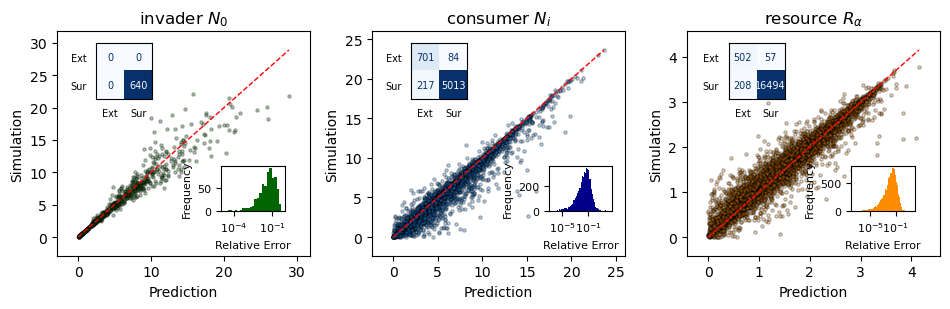

In [16]:
from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['sim_Nbools']])
prediction_Nbool_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['prediction_Nbool']])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(monod_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(monod_unpacked_data['prediction_Rbool'])
intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(monod_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(monod_unpacked_data['predictionRs'])[positive_indices_R]


filtered_simulationN_after = np.concatenate(monod_unpacked_data['simulationN_after'])[positive_indices_N]
filtered_predictionNs = np.concatenate(monod_unpacked_data['predictionNs'])[positive_indices_N]

# Calculate R^2 values
#r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
#r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(monod_unpacked_data['predictionNs']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated, prediction_Nbool_concatenated, ax=inset_ax_n)


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(monod_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_title(f'resource $R_α$')

# Add confusion matrix inset for R
inset_ax_r = ax[2].inset_axes([0.15, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Rbools_concatenated, prediction_Rbool_concatenated, ax=inset_ax_r)

# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xlim([-8, 2])  # Set x-axis limits

ax_hist2.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


simulation_invader = np.array(monod_unpacked_data['invader_ODE_steady_states'])
prediction_invader = np.array(monod_unpacked_data['invader_predictions'])


sim_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['prediction_Nbool']])

intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]

N0_positive_indices = np.array(intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)

# Handle potential division by zero and inf/nan values for R histogram
relative_error_R = np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after
relative_error_R = relative_error_R[np.isfinite(relative_error_R) & (relative_error_R > 0)]  # Remove zeros and inf/nan
if len(relative_error_R) > 0:
    log_relative_error_R = np.log10(relative_error_R)
    log_relative_error_R = log_relative_error_R[np.isfinite(log_relative_error_R)]  # Remove any remaining inf/nan after log

# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_title(f'invader $N_0$')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool, pred_invader_bool, ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)

ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xlim([-5, 0])  # Set x-axis limits from 10^-2 to 10^1

ax_hist0.set_xticks([-4, -1])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-4}$', '$10^{-1}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("Monod_work.pdf", format="pdf")

plt.show()